# Chaos detection and trajectory type classification in dynamical systems

In various fields of physics (particle accelerators, plasma physics, celestial mechanics, astrophysics, and others), deterministic dynamical systems are used to model physical processes. That is, the evolution of the system over time is determined solely by the initial conditions. These dynamical systems can be described by differential equations or discrete mappings.

There exist solutions (trajectories in phase space) that are exponentially sensitive to small perturbations in initial conditions. Such trajectories are called **chaotic**, while trajectories for which such sensitivity is not exhibited are called **regular**.

Determining the type of trajectory is a common task. Depending on the application, the presence of chaotic trajectories may be undesirable, for example, in the stable motion region of circular particle accelerators, or desirable, for example, in the uniform mixing of two liquids.

There are numerous methods for determining the type of trajectories, which can be roughly divided into two groups. Chaos indicators in the first group are based on the direct use of phase space trajectories or orbits (time history). The other group utilizes information about the tangent dynamics. In all cases, the results depend on the length of the trajectories, the computation of which can be time-consuming.

# Tasks

- Is it possible to use ML methods for classification using (relativly) small datasets (trajectories of shorter length)?
- Are such classifiers capable to generalize? Are classification results meaningfull when applied to the same mapping with different set of knobs or to a different mapping?
- Is it possible to obtain some low dimensional representation?

# Test problem

Consider a simple polinomial symplectic mapping on a plane:

$$
\begin{aligned}
& q \to p \\
& p \to -q + \omega p + (1 - s) p^2 + s p^3
\end{aligned}
$$

where $q \in [-1, 1]$ and $p \in [-1, 1]$, parameters for training data are $\omega=\frac{1}{2}$ and $s=0$.

This mapping can be used to describe nonlinear dynamics in a simplified model of a circular accelerator.

Inside $[-1, 1] \times [-1, 1]$, there exists a region with stable regular initial conditions, which is surrounded by a region with chaotic initial conditions. Chaotic trajectories may remain bounded for a large number of iterations, but, in the limit of an infinite number of iterations, they become unstable.

In the context of particle accelerators, the size of the stable region is of importance. The presence of chaotic trajectories interferes with the estimation of the size of this region. Therefore, one of the methods for chaos detetion should be used at some stage. Computation of a large set of trajectories in realistic models takes a lot of time (it is necessary to compute for each initial condition on a dense grid).

Here, we use REM, FMA and GALI indicators to setup a baseline (refer to [https://doi.org/10.1103/PhysRevE.107.064209](https://doi.org/10.1103/PhysRevE.107.064209) for performance comparison of conventional chaos indicators). This baseline can be used to assert the performance of various ML based methods.

# Dataset (description)

- Coordinates $q(n)$ (or $q(n)$ together with $p(n)$) can be used as a feature corresponding to each initial condition within the region of interest (time series or multivariate time series, respectivly). These signals can be used directly in unsupervised classification. For $[-1, 1] \times [-1, 1]$ region the number of regular trajectories is much larger than the nubler of chaotic ones. This makes corresponding dataset imbalances, chaotic orbits can be treated as anomalies.

- Using coventional chaos detection methods (REM, FMA or GALI) it is possible label data. These chaos indicators produce continues values within a range. Thresholding or other means can be applied to index each point as regular (0) or chaotic (1). Lables can be used to train supervised classificators or turn hyperparameters.

- Two dense grids (imbalenced region and balanced) are used to compute chaos indicators using relativly large number of iterations (ground truth). These indicators are used to label coresponding initial conditions (continuous indicator values and 0/1 labes are computed for each indicator). Mask for all bounded initial conditions is used to illustate the dependence of chaos indicator on trajectory length.

- Using bounded initials two dataset are created containig 10% of points. For each dataset chaos indicators are computed using several fixed sizes (256, 512 and 1024). The performance is compared with the ground truth.   

- These short datasets are also used to generate trajectories (1024 iterations max). Functions to generate trajectories are provided along with corresponding labels (continuous indicator values and 0/1 labes are computed for each indicator). Function to generate samples from a trajectory is also provided (shifted window).

# Chaotic trajectories

In this section, we consider how regular and chaotic trajectories visualy look and discuss some features of chaotic trajectories.
Additionally, a conventional classification method (REM) is used for illustration, which is based on return error of an initial condition into itself.
The initial condition is iterated forward in time, then backward, and compared to the original value.
For chaotic trajectories, such a procedure is much more sensitive to rounding errors.

In [1]:
# Import (numba jit compilation will take about 5 seconds)

import numpy
import chaos

from matplotlib import pyplot as plt
from matplotlib import colormaps

In [2]:
# Fix mapping parametes (knobs)

k = numpy.array([0.5, 0.0])

In [3]:
# Compute and plot several phase space trajectories

# chaos.orbit -- use to generate one trajectory
# chaos.table -- use to generate several trajectories

# Set number of iterations

n = 2**12

# Set initial conditions

q = numpy.linspace(0.1, 0.8, 11)
p = numpy.linspace(0.1, 0.7, 11)
x = numpy.stack([q, p]).T

# Compute
# Output shape is (number of initials, phase space dimension, number of iterations + 1)

xs = chaos.table(n, k, x)

# Set coordinates and momenta

qs, ps = xs.swapaxes(1, -1).swapaxes(0, 1)

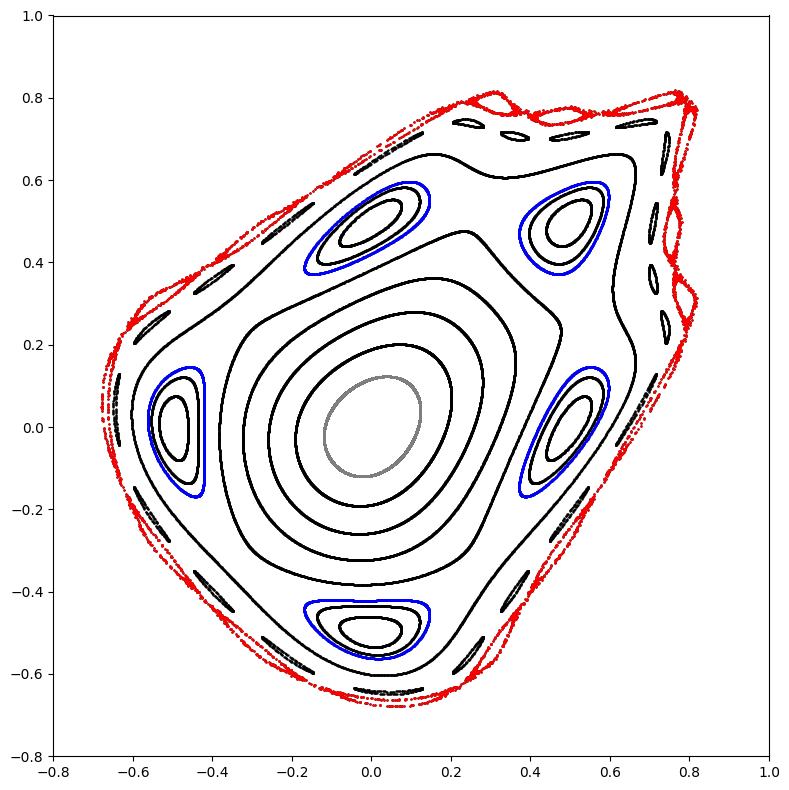

In [4]:
# Plot

plt.figure(figsize=(8, 8))
plt.scatter(qs, ps, color='black', s=0.5)
plt.scatter(qs[0], ps[0], color='gray', s=0.5)
plt.scatter(qs[7], ps[7], color='blue', s=0.5)
plt.scatter(qs[-1], ps[-1], color='red', s=0.5)
plt.xlim(-0.8, 1.0)
plt.ylim(-0.8, 1.0)
plt.tight_layout()
plt.show()

# gray -- regular trajectory near the origin
# blue -- regular resonant trajectory (frequency is close to a rational value and it is highly nonlinear)
# red  -- chaotic trajectory

# Note, resonant trajectory being very nonlinear can be confused with a chaotic one
# FMA in particular is especially sensitive to resonances
# In some sence it is OK to include them into a singe class

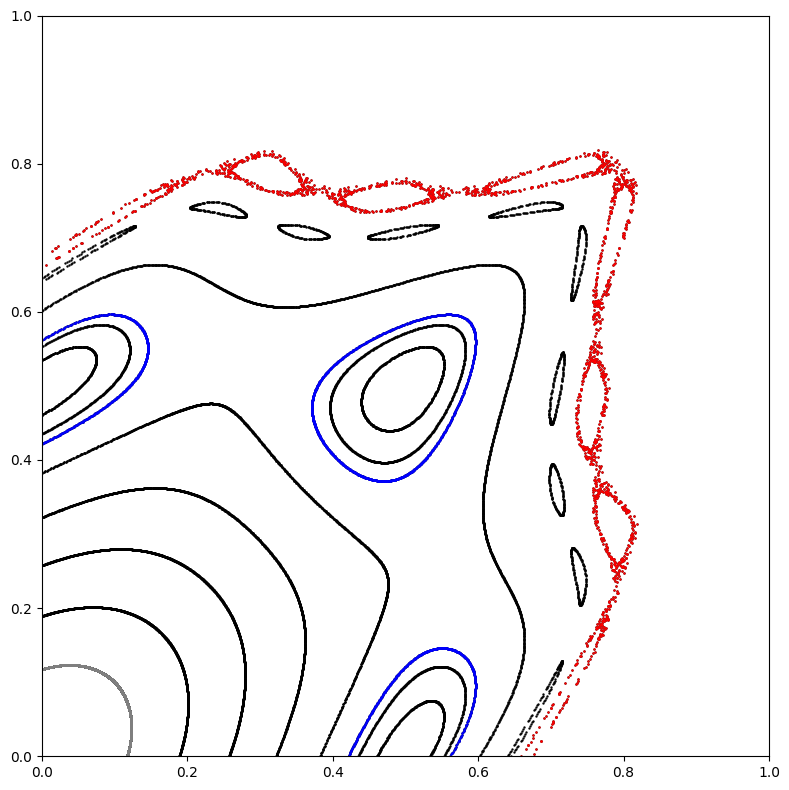

In [5]:
# Zoom

plt.figure(figsize=(8, 8))
plt.scatter(qs, ps, color='black', s=0.5)
plt.scatter(qs[0], ps[0], color='gray', s=0.5)
plt.scatter(qs[7], ps[7], color='blue', s=0.5)
plt.scatter(qs[-1], ps[-1], color='red', s=0.5)
plt.xlim(-0., 1.0)
plt.ylim(-0., 1.0)
plt.tight_layout()
plt.show()

# Note, regular trajectories look one dimentional (for 2d case), while this is not true in chaotic case
# In fact, chaotic trajectory has fractional dimension

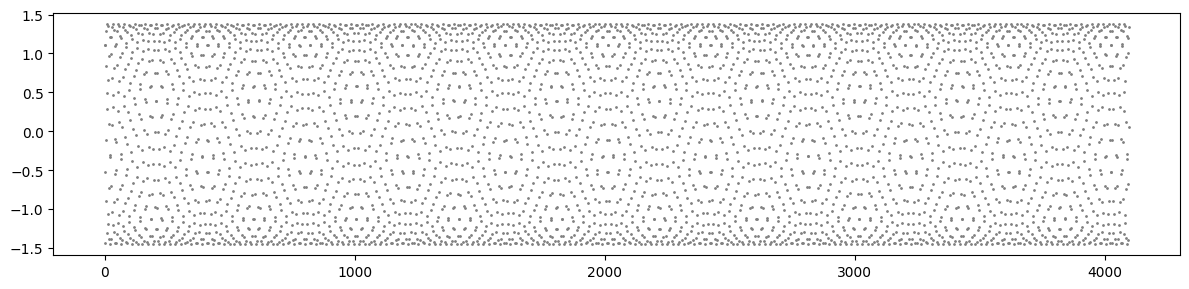

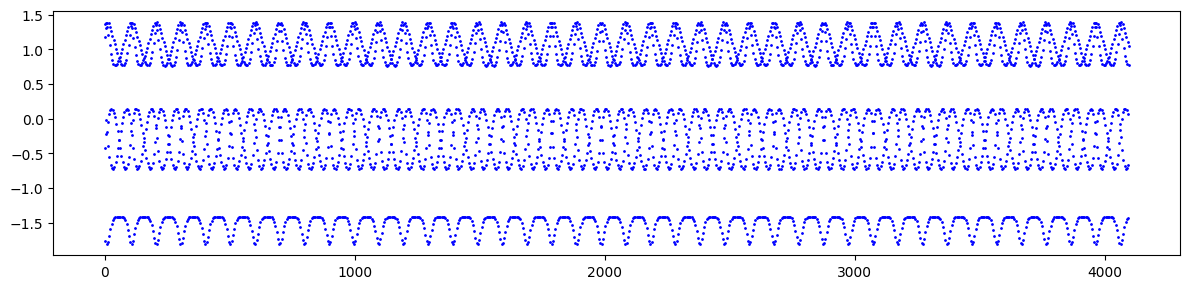

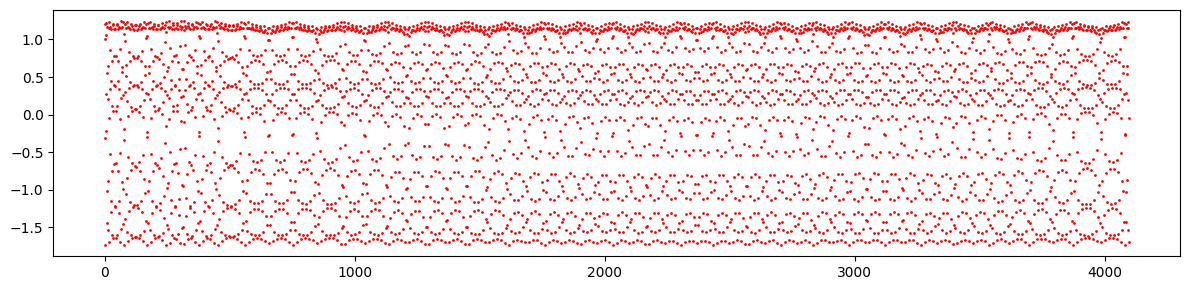

In [6]:
# Here are the same normalized trajectories vs iteration number
# Clearly, regular trajectories have more structure to them

plt.figure(figsize=(12, 3))
plt.scatter(range(2**12 + 1), (qs[0] - numpy.mean(qs[0]))/numpy.std(qs[0]), color='gray', s=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.scatter(range(2**12 + 1), (qs[7] - numpy.mean(qs[7]))/numpy.std(qs[7]), color='blue', s=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.scatter(range(2**12 + 1), (qs[-1] - numpy.mean(qs[-1]))/numpy.std(qs[-1]), color='red', s=1)
plt.tight_layout()
plt.show()

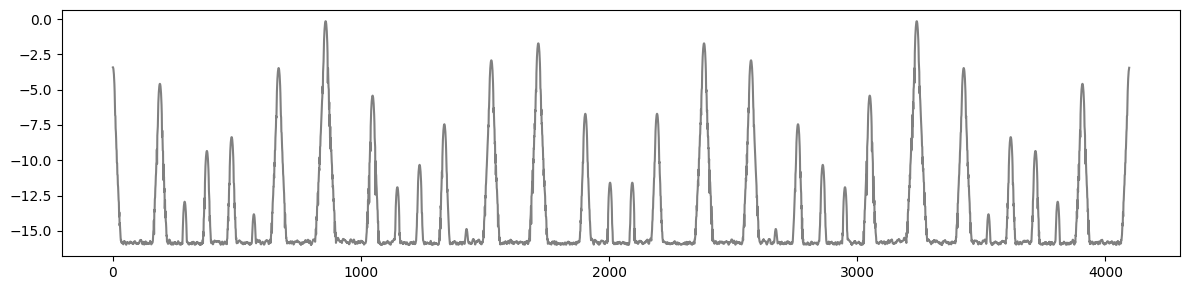

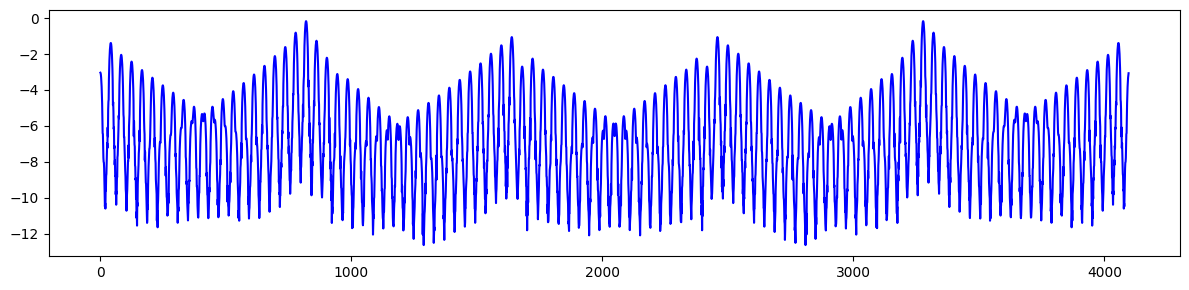

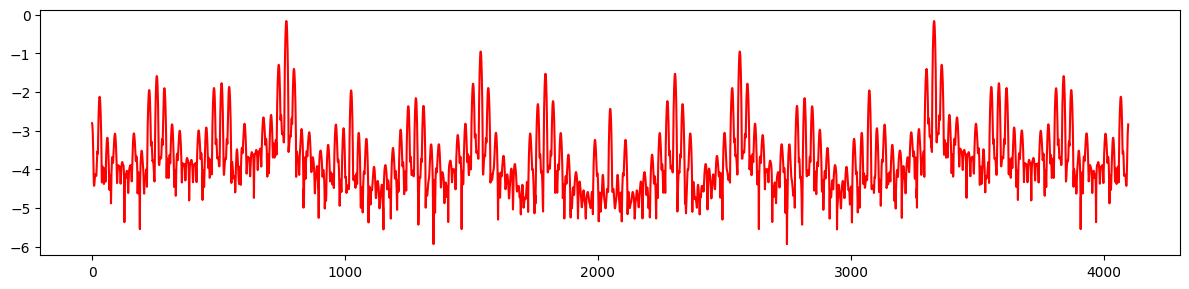

In [7]:
# Corresponding fourier amplitude spectra (with window)

f = chaos.window(2**12 + 1, 2.0)

plt.figure(figsize=(12, 3))
plt.errorbar(range(2**12 + 1), numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[0] - numpy.mean(qs[0]))/numpy.std(qs[0])))), color='gray', ms=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.errorbar(range(2**12 + 1), numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[7] - numpy.mean(qs[7]))/numpy.std(qs[7])))), color='blue', ms=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.errorbar(range(2**12 + 1),  numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[-1] - numpy.mean(qs[-1]))/numpy.std(qs[-1])))), color='red', ms=1)
plt.tight_layout()
plt.show()

In [8]:
# Set grid for conventional classification method

s = 2001
n = 2**12

q = numpy.linspace(-1.0, 1.0, s)
p = numpy.linspace(-1.0, 1.0, s)

x = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
x.shape

(4004001, 2)

In [9]:
%%time

# Compute REM indicator for each initial value using 2**12 forward iterations and 2**12 inverse iterations
# Output is winsorized into [-15, 0]
# The value -15 is set as a base accuracy level for REM (also true for other indicators)
# Indicator returns log10 of reverse distance
# NaN value correspond to unbounded initial (overflow)
# Some initials might produce values larger than zero, these values can be dropped or winsorized to here (like it is done here)

out = chaos.rem(n, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 1h 39min 19s, sys: 2.75 s, total: 1h 39min 22s
Wall time: 6min 21s


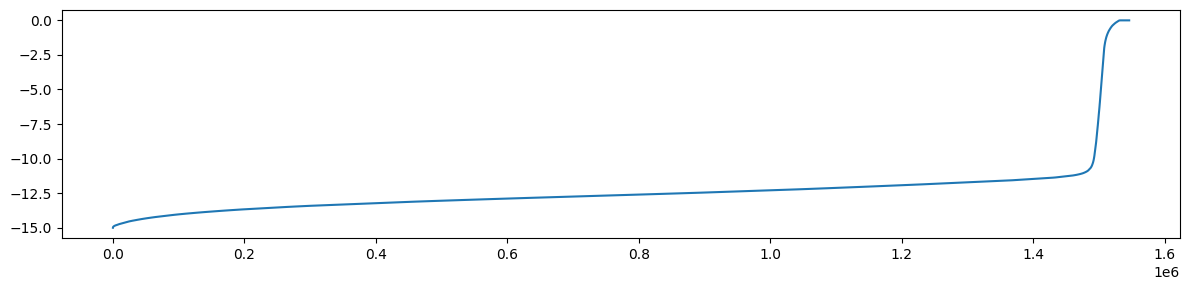

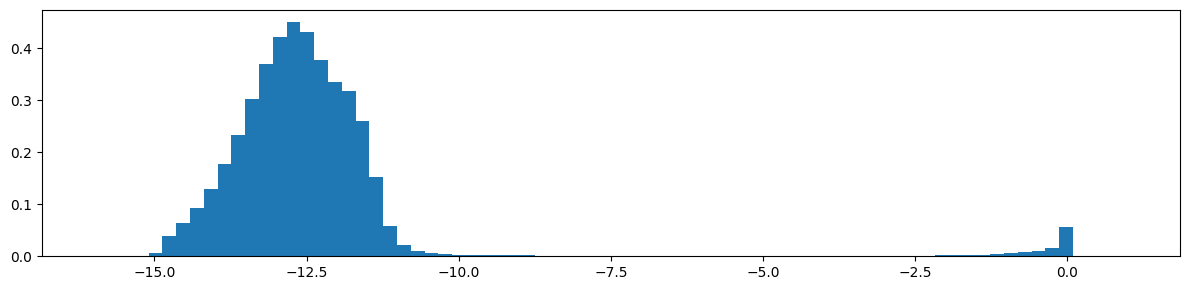

In [10]:
# Plot sorted indicator values for all stable initials (not NaNs after 2**12 iterations)
# The elbow indicates two different classes, there is also a transition region
# These values can be used as labels in supervised methods or a threshold can be set to get binary labels

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

# Plot corresponding historgam
# As expected, the distribution of indicator values looks bimodal
# In the [-1, 1] x [-1, 1] region most of the trajectories are regular
# Hence, the data set is imbalanced

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=75, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

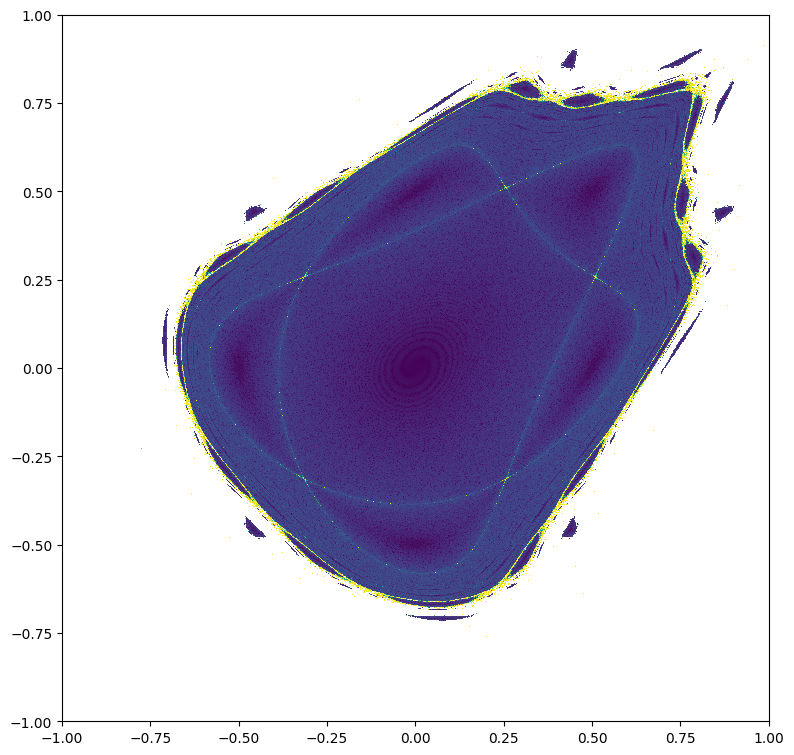

In [11]:
# Plot indicators
# Yellow region (lighter colors) corresponds to chaotic trajectories

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(-1, 1, -1, 1))
plt.tight_layout()
plt.show()

In [12]:
# Set zoom grid (chaotic sea region)

s = 2001
n = 2**12

q = numpy.linspace(0.725, 0.825, s)
p = numpy.linspace(0.725, 0.825, s)

x = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
x.shape

(4004001, 2)

In [13]:
%%time

# Compute and winsorize

out = chaos.rem(n, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 1h 40min 18s, sys: 2.33 s, total: 1h 40min 20s
Wall time: 6min 25s


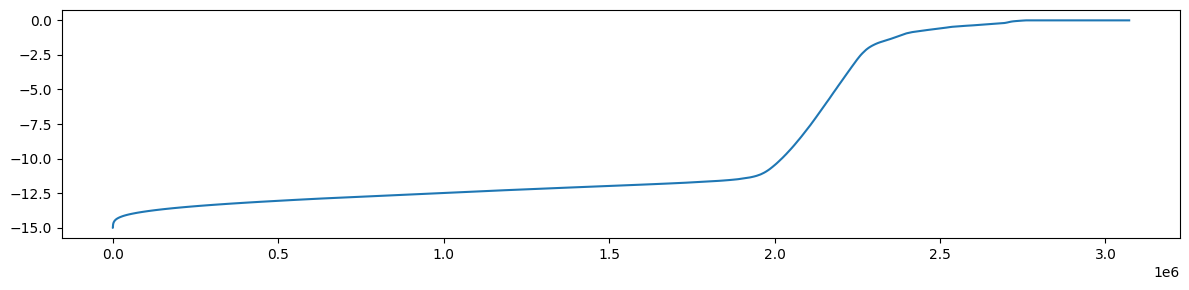

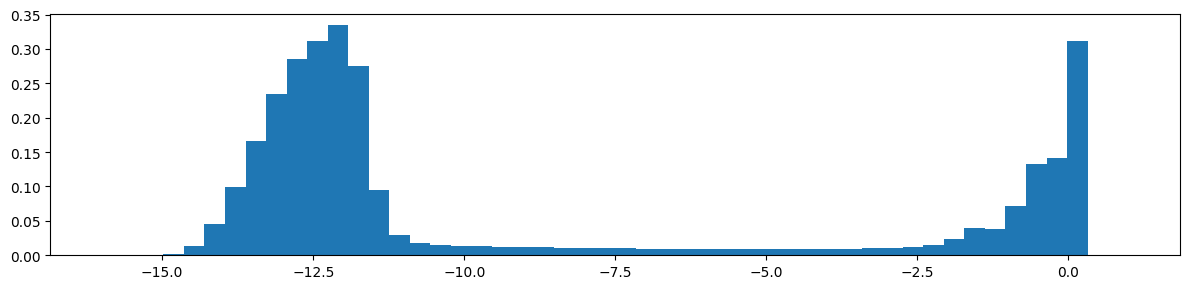

In [14]:
# Plot sorted indicator

# In the case of zoomed region data is better balanced (number of regular and chaotic initials is comparable)

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=50, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

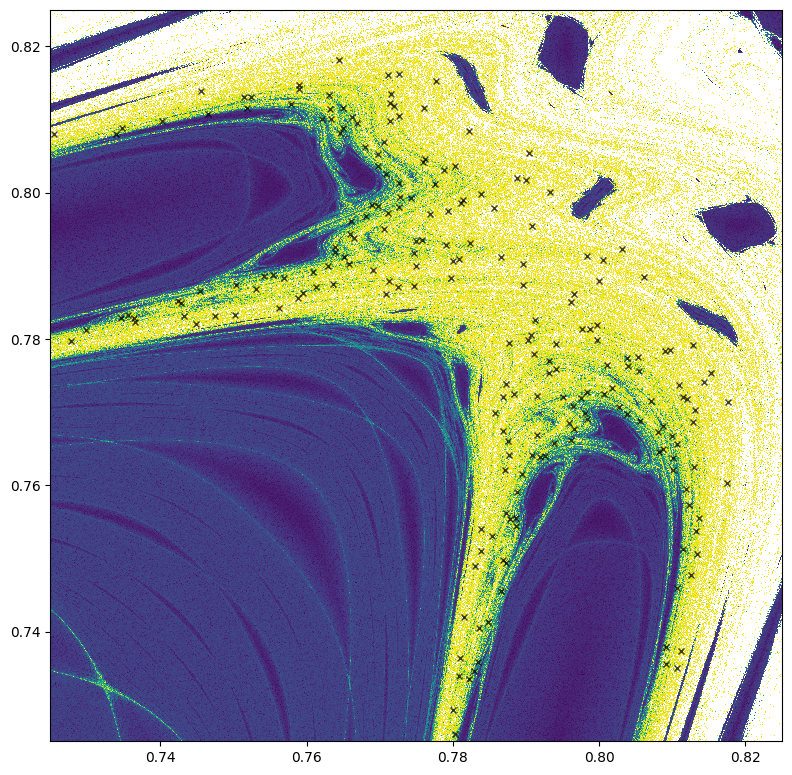

In [15]:
# Plot zoomed region along with a sample chaotic trajectory

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(0.725, 0.825, 0.725, 0.825))
plt.errorbar(qs[-1], ps[-1], color='black', fmt=' ', ms=5, marker='x', alpha=0.75)
plt.xlim(0.725, 0.825)
plt.ylim(0.725, 0.825)
plt.tight_layout()
plt.show()

In [16]:
# Set zoom grid (chain structure, hyperbolic manifold)

s = 2001
n = 2**12

q = numpy.linspace(0.73, 0.735, s)
p = numpy.linspace(0.73, 0.735, s)

x = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
x.shape

(4004001, 2)

In [17]:
%%time

# Compute and winsorize

out = chaos.rem(n, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 1h 40min 1s, sys: 1.84 s, total: 1h 40min 3s
Wall time: 6min 26s


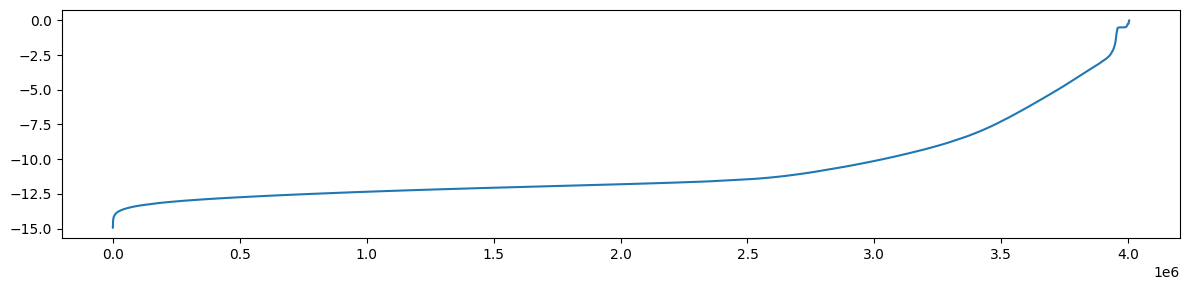

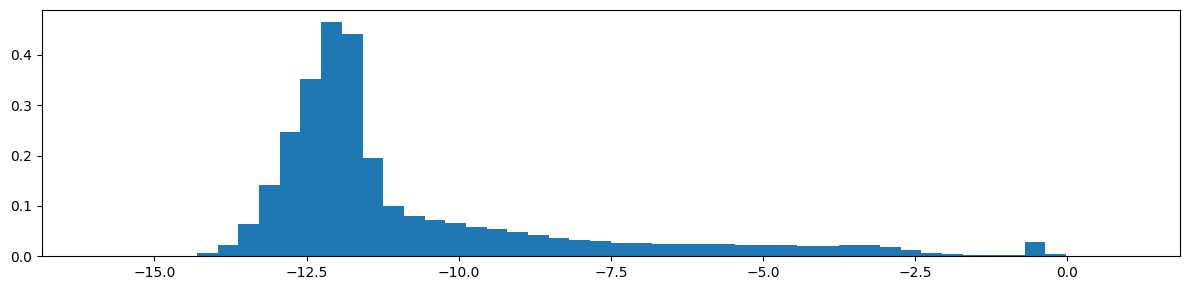

In [18]:
# Plot sorted indicator

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=50, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

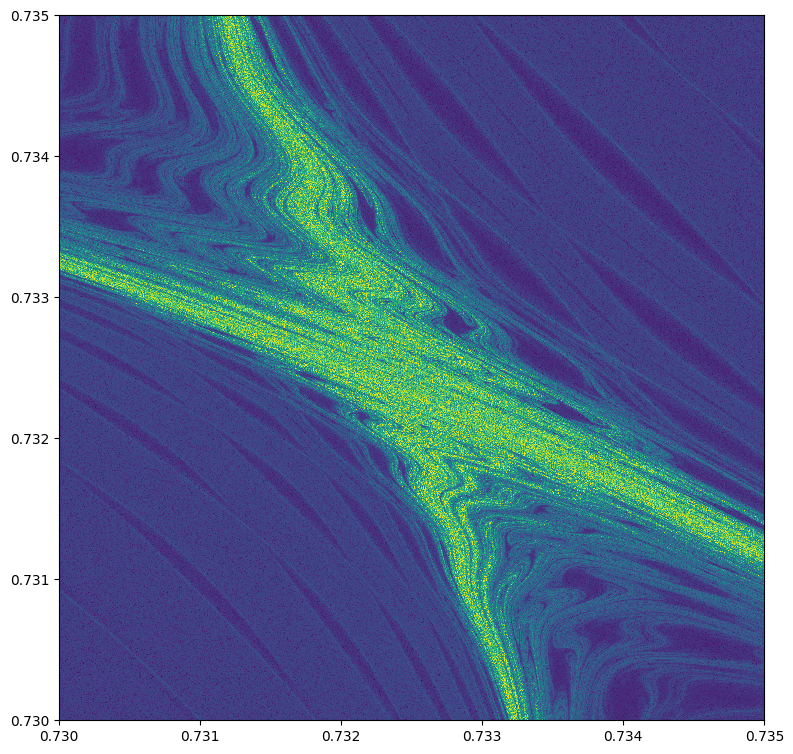

In [19]:
# Plot zoomed region

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(0.73, 0.735, 0.73, 0.735))
plt.tight_layout()
plt.show()

# Chaos indicators (demo)

In this section, application of common chaos indicators are illustrated. Three indicators are considered: REM (Eeverse Error Method, it also was used in ther previous section), FMA (Frequency Map Analysis) and GALI (Generalized ALignment Indices). For theoretical background refer to [https://doi.org/10.1103/PhysRevE.107.064209](https://doi.org/10.1103/PhysRevE.107.064209) and referencies within.

- REM indicator is based of the analysis of the return error. The mapping is first iterated $n$ times, next, using the result, mapping is iterated back in time (using the corresponding inverse). The final result is supposed to match the original intitial condition. Due to finite precision math, the is a return error. This error is particularly sensitive to chaotic nature of trajectories. Thus, if the return error is used as a chaos indicator, it is possible to discriminate regular and chaotic initial conditions.

- FMA indicator relies on accurate frequency estimation. Frequency is expected to be fixed by initial condition. For a given trajectory it is possible to use its different parts to estimate frequncy, for example frequency could be estimated using the first $n$ iterations and the last $n$ iterations. Despite the concept of frequency being vague in chaotic case, it is still can be argued to have some meaning. The differnce in estimated frequencies can be used to construct chaos indicator. For chaotic trajectories the disparency is expected to be larger than for regular trajectories.

- GALI indicator is related to tangent dynamics of the mapping. In this case, the dynamics of tangent vectors is observed. Given two or more initially linear independent vectors attached to a given initial condition. Their evolution is obtained using mapping Jacobian. After a certain amount of time the vectors are becoming alligned (they become linearly dependent, which might be observed using eigenvalues build from these vectors). In general this is true for all initial conditions (except 2D case, for regular initials product of eigenvalues will not become zero). For chaotic initials, this indicator decays exponentially fast. 

In [1]:
# Import (numba jit compilation will take about 5 seconds)

import numpy
import chaos

from matplotlib import pyplot as plt
from matplotlib import colormaps

In [2]:
# Fix mapping parametes (knobs)

k = numpy.array([0.5, 0.0])

In [3]:
# Set grid for conventional classification method

# Note, for GALI indicator, random initial vectors can be uses
# FMA performs 2*n iterations

s = 2001
n = 2**12

q = numpy.linspace(-1.0, 1.0, s)
p = numpy.linspace(-1.0, 1.0, s)

x = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
v = numpy.ascontiguousarray(s*s*[[[1.0, 1.0], [0.0, 1.0]]])
x.shape, v.shape

((4004001, 2), (4004001, 2, 2))

In [4]:
%%time

# REM

out = chaos.rem(n, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 1h 4min 36s, sys: 564 ms, total: 1h 4min 37s
Wall time: 4min 6s


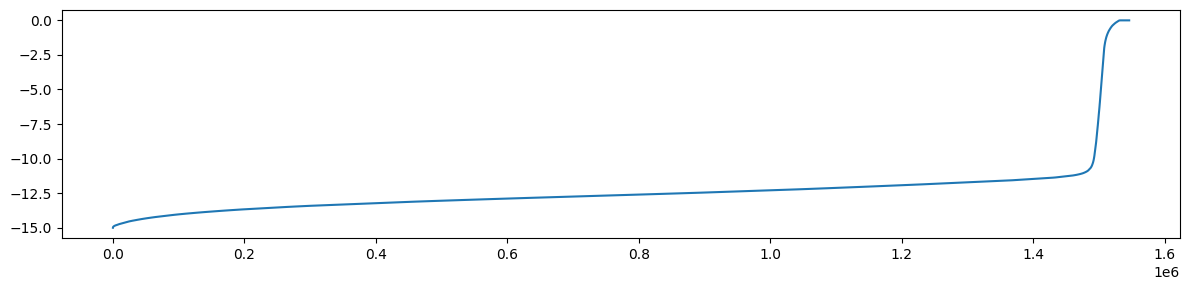

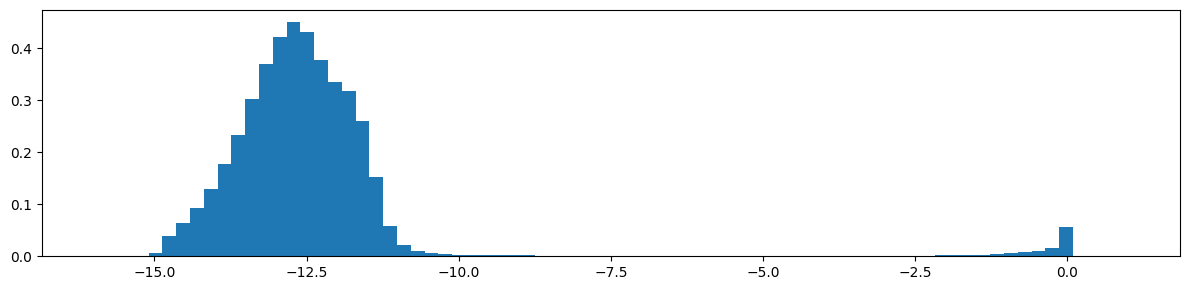

In [5]:
# Plot sorted indicator values and historgam

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=75, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

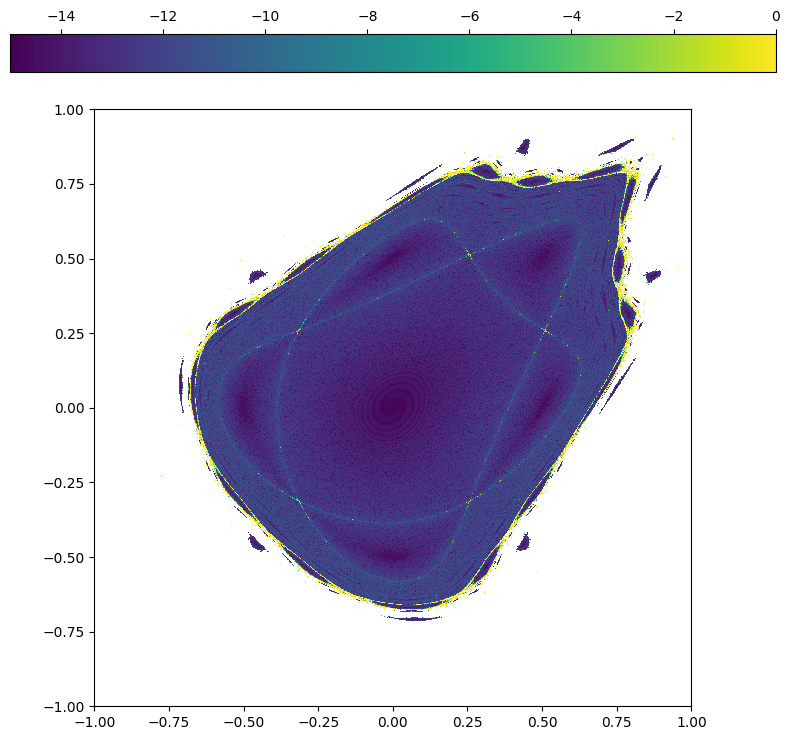

In [6]:
# Plot indicators
# Yellow region (lighter colors) corresponds to chaotic trajectories

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(-1, 1, -1, 1))
plt.colorbar(location='top')
plt.tight_layout()
plt.show()

In [7]:
%%time

# FMA

# Note, for FMA 2n iterations are performed
# Frequency is estimated from the first and the last n iterations

# For REM n forward and n inverse iterations are performed, 2n in total

f = chaos.window(n, 1.0)
out = chaos.fma(f, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 1h 19min 13s, sys: 202 ms, total: 1h 19min 14s
Wall time: 5min 11s


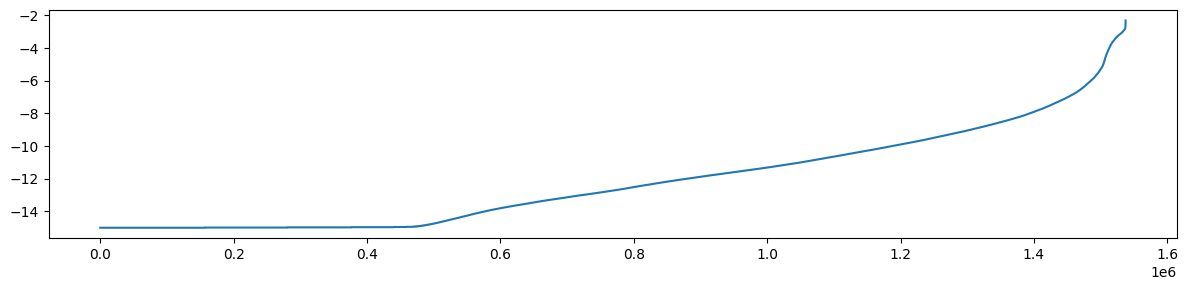

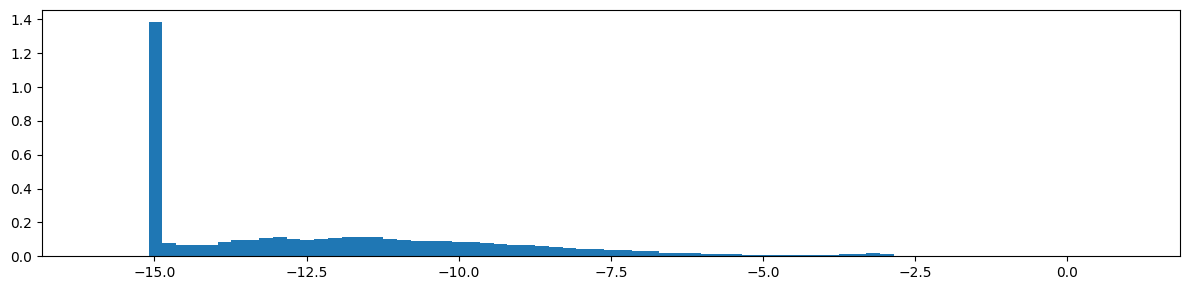

In [8]:
# Plot sorted indicator values and historgam

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=75, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

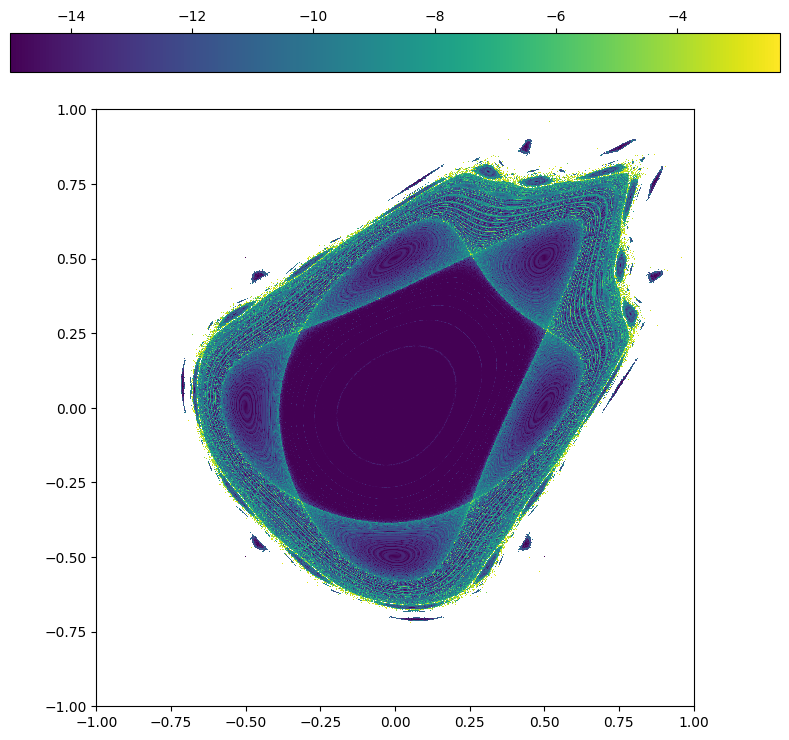

In [9]:
# Plot indicators
# Yellow region (lighter colors) corresponds to chaotic trajectories

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(-1, 1, -1, 1))
plt.colorbar(location='top')
plt.tight_layout()
plt.show()

In [10]:
%%time

# GALI

# Here, n forward mapping and jacobian iterations are performed
# Computational overhead is raughtly 10x

out = chaos.gali(n, k, x, v)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

# Note, for GALI indicators small values correspond to chaotic initials
# Here we flip the indicator sign and shift the result 

out = -15.0 - out 

CPU times: user 8h 22min 43s, sys: 1.05 s, total: 8h 22min 44s
Wall time: 31min 35s


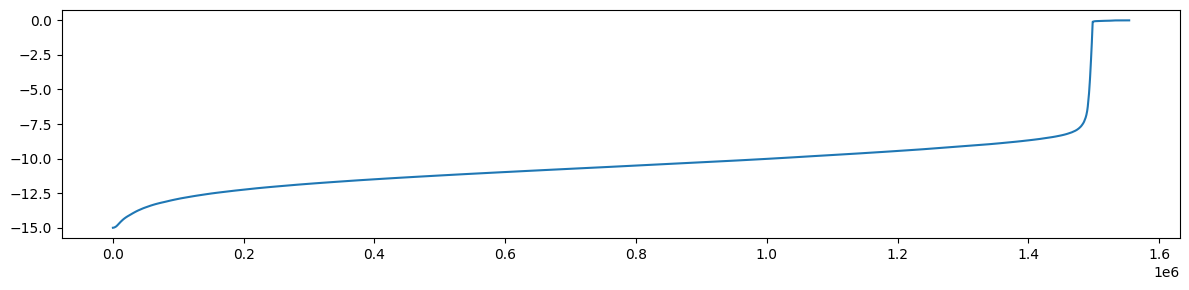

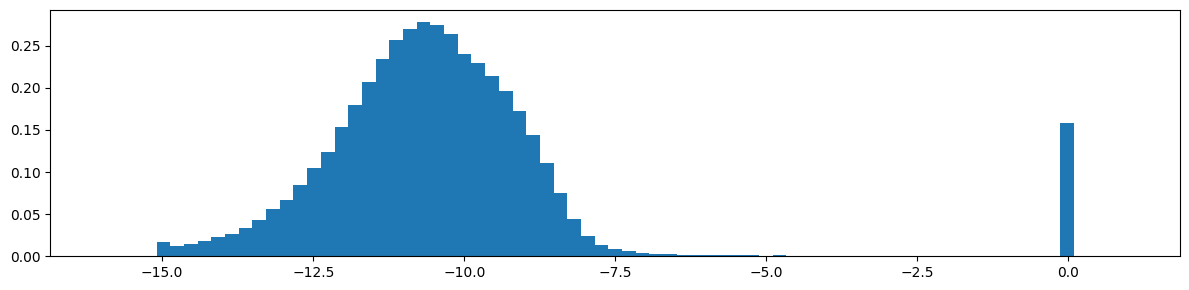

In [11]:
# Plot sorted indicator values and historgam

indicator = numpy.sort(out.flatten())

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator[~numpy.isnan(indicator)], bins=75, range=(-16, 1), density=True)
plt.tight_layout()
plt.show()

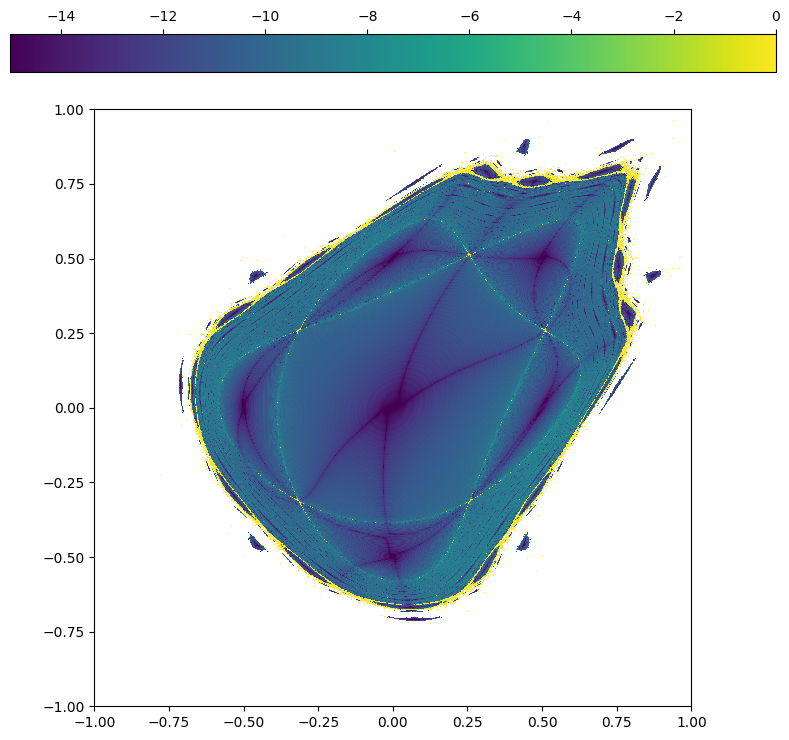

In [12]:
# Plot indicators
# Yellow region (lighter colors) corresponds to chaotic trajectories

# The artifacts (darker curves coming out from elliptic fixed points) are due to section of initial deviation vectors.
# Different initial vectors ([[1, 1], [0, 1] used here) will result in a different pattern of curves. 
# Overall, these artifacts do not influence classification.

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(-1, 1, -1, 1))
plt.colorbar(location='top')
plt.tight_layout()
plt.show()

# Chaos indicators (classification)

In this section the results of REM chaos indicator are used to perform binary classification.

In [1]:
# Import (numba jit compilation will take about 5 seconds)

import numpy
import chaos

from matplotlib import pyplot as plt
from matplotlib import colormaps

In [2]:
# Fix mapping parametes (knobs)

k = numpy.array([0.5, 0.0])

In [3]:
# Set grid for REM indicator

s = 2001
n = 2**12

q = numpy.linspace(0.725, 0.825, s)
p = numpy.linspace(0.725, 0.825, s)

x = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
x.shape

(4004001, 2)

In [4]:
%%time

# Compute indicator

out = chaos.rem(n, k, x)
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 15.0] = -15.0

CPU times: user 52min 23s, sys: 2.46 s, total: 52min 25s
Wall time: 3min 23s


In [5]:
# Classify with KDE

from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

indicator = numpy.sort(out.flatten())
indicator = indicator[~numpy.isnan(indicator)].reshape(-1, 1)

points = numpy.linspace(-16.0, 1.0, 251)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(indicator)

score = kde.score_samples(points.reshape(-1, 1))

peaks, info = find_peaks(score, height=(None, None))
*_, chaotic, regular = peaks[numpy.exp(info['peak_heights']).argsort()]
position = numpy.exp(score[regular:chaotic]).argmin()
threshold = points[position]

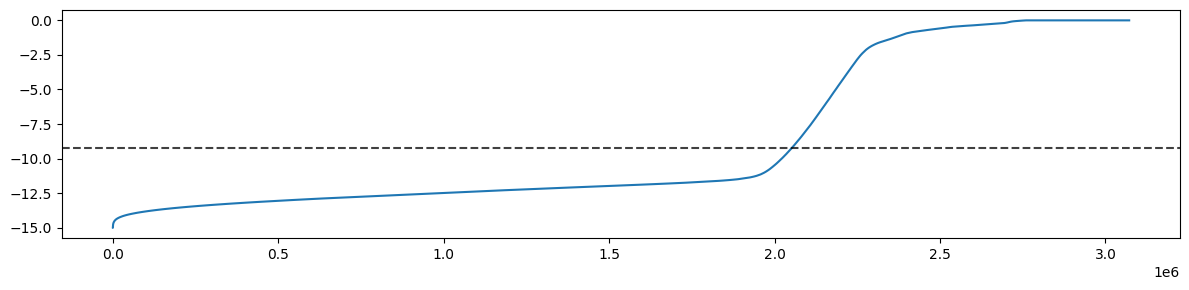

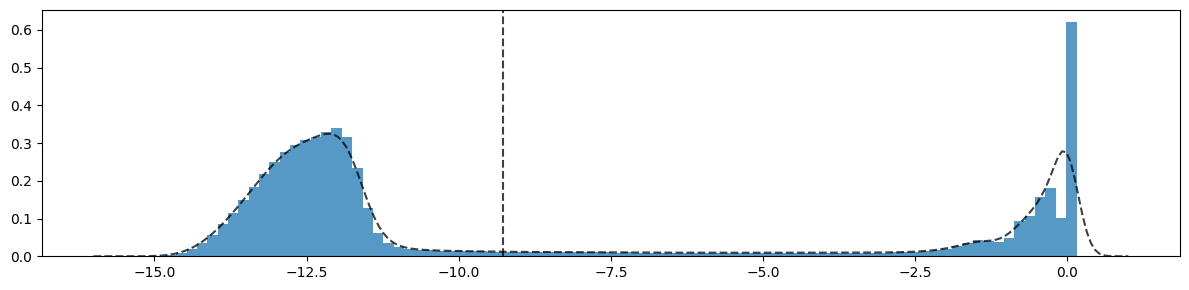

In [6]:
# Plot elbow and historgam along with KDE 

plt.figure(figsize=(12, 3))
plt.plot(indicator)
plt.axhline(threshold, linestyle='dashed', color='black', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.hist(indicator, bins=100, range=(-16, 1), density=True, alpha=0.75)
plt.plot(points, numpy.exp(score), color='black', linestyle='dashed', alpha=0.75)
plt.axvline(threshold, linestyle='dashed', color='black', alpha=0.75)
plt.tight_layout()
plt.show()

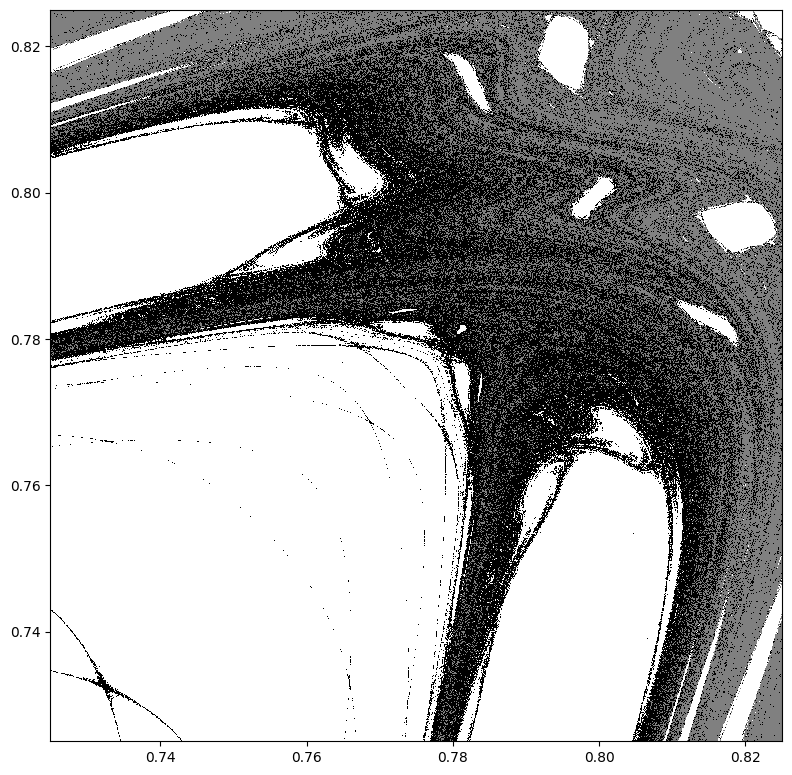

In [7]:
# white -- regular
# black -- chaotic

table = numpy.copy(out)
table = numpy.where(table >= threshold, 0.0, 1.0)
table[numpy.isnan(out)] = float('nan')

cmap = colormaps.get_cmap('gray')
cmap.set_bad(color='gray')

plt.figure(figsize=(8, 8))
plt.imshow(table, aspect='equal', origin='lower', interpolation='nearest', cmap=cmap, extent=(0.725, 0.825, 0.725, 0.825))
plt.tight_layout()
plt.show()

In [8]:
# (number of chaotic initials)/(number of regular initials)

numpy.sum(table==1)/numpy.sum(table==0)

2.0079898078294045

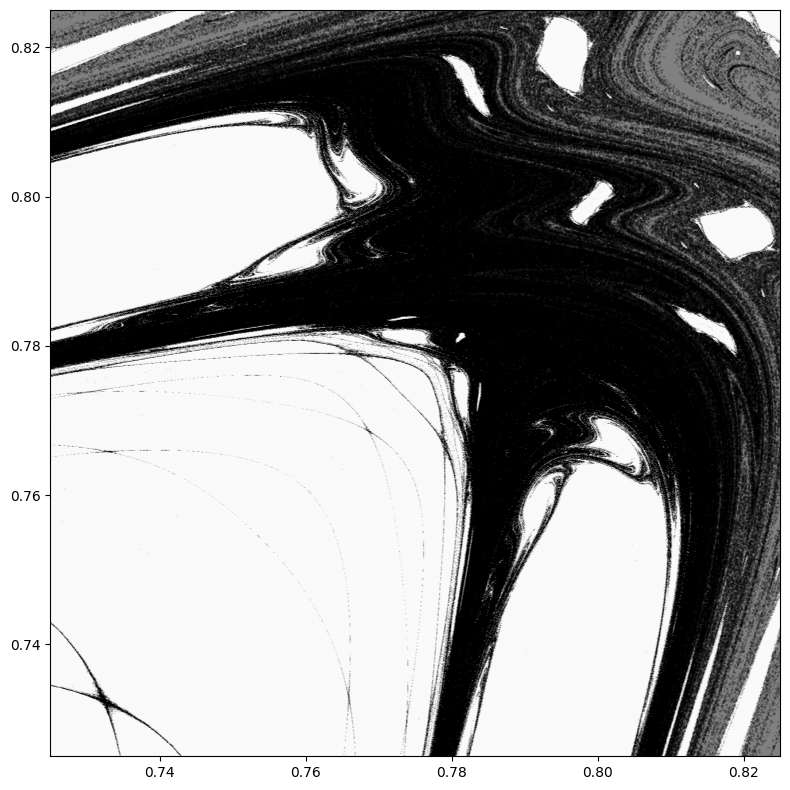

In [9]:
# Labeled dataset

bounded = ~numpy.isnan(table.flatten())

X = x[bounded]
y = table.flatten()[bounded]

plt.figure(figsize=(8, 8))
plt.gca().set_facecolor('gray')
plt.scatter(*X.T, c=y, cmap=cmap, s=0.01)
plt.xlim(0.725, 0.825)
plt.ylim(0.725, 0.825)
plt.tight_layout()
plt.show()

# Survival mask

In [ ]:
2*2**12 (# used if fma)

# REM

In [ ]:
# compute confusion matrix (or sklearn.metrics.roc_auc_score)

# FMA

# GALI

# Dataset (generation utils)